Student seating preferences are handled on a first-come first serve basis. If the company table that the student wants to sit at is full, we move on to their next preference. Otherwise, we seat the student at the table and move on to the next student.

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
os.listdir()

['SampleLPFinal.xlsx',
 'SeatingLP.ipynb',
 'LPformulation',
 '.DS_Store',
 'README.md',
 'SampleCompanies.csv',
 '.ipynb_checkpoints',
 'SimpleSeating.ipynb',
 '.git',
 'SampleFinal.xlsx',
 'SampleStudents.csv']

### Import data

In [3]:
companies_df = pd.read_csv('SampleCompanies.csv')

In [4]:
companies_df

,Company,Maximum load
0,Company A,6
1,Company B,12
2,Company C,6
3,Company D,6
4,Company E,6
5,Company F,7
6,Company G,6


In [5]:
students_df = pd.read_csv('SampleStudents.csv')

In [6]:
students_df.head()

,What is your name?,#1 Interest,#2 Interest,#3 Interest,#4 Interest,#5 Interest,#6 Interest,#7 Interest
0,Jamie Obrien,Company A,Company B,Company C,Company D,Company E,Company F,Company G
1,Gilberto Ortega,Company G,Company D,Company C,Company B,Company A,Company E,Company F
2,Anne Tyler,Company B,Company E,Company G,Company A,Company F,Company D,Company C
3,Marshall Underwood,Company G,Company B,Company C,Company E,Company A,Company F,Company D
4,Nicholas Howard,Company E,Company D,Company F,Company B,Company A,Company C,Company G


### Specify number of rotations to event

In [7]:
rotations = 3

### Seat students

In [8]:
# Extract dataframe info into a dict
student_preferences = {}
for row in students_df.itertuples():
    student_preferences[row[1]] = list(row[2:])
# Extract company info into a dict
company_capacity = {}
for row in companies_df.itertuples():
    company_capacity[row[1]] = {"max" : row[2]}

In [9]:
# copy original dictionary
import copy
student_preferences_orig = copy.deepcopy(student_preferences)

In [10]:
# store lists of who is sitting where at each rotation
student_seating = {student: {} for student in student_preferences}
company_seating = {company: {} for company in company_capacity}
# for each rotation
for r in np.arange(rotations):
    rotation_name = 'rotation' + str(r + 1)
    # for each student
    for student in student_preferences:
        # iterate through preference list until find a company that has seats
        company_for_this_rotation = ""
        for company in student_preferences[student]:
            # if company currently does not have a list of students for the rotation, add it
            if not company_seating[company].get(rotation_name):
                company_seating[company][rotation_name] = []
            # if there is still space at the table for this rotation
            if len(company_seating[company][rotation_name]) < company_capacity[company]['max']:
                company_for_this_rotation = company
                # remove company from preference list
                student_preferences[student].remove(company_for_this_rotation)
                break
        # add company as student's seating assignment for this rotation
        student_seating[student][rotation_name] = company_for_this_rotation
        # add student to company's seating list for this rotation
        if company_for_this_rotation:
            company_seating[company][rotation_name].append(student)
# calculate satisfaction scores
for student in student_seating:
    satisfaction_score = 0
    n = len(student_preferences_orig[student])
    for rotation_name in student_seating[student]:
        if student_seating[student][rotation_name] in student_preferences_orig[student]:
            satisfaction_score += n-student_preferences_orig[student].index(student_seating[student][rotation_name])
    # normalize score
    satisfaction_score /= sum([n - r for r in np.arange(rotations)])
    student_seating[student]['satisfaction'] = satisfaction_score

In [11]:
student_seating_df = pd.DataFrame.from_dict(data=student_seating, orient='index')

In [12]:
company_seating_df = pd.DataFrame.from_dict(data=company_seating, orient='index')

### Export to Excel

In [13]:
# write to excel
from pandas import ExcelWriter

In [14]:
def save_xls(list_dfs, xls_path, sheet_names):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer, sheet_names[n])
        writer.save()

In [15]:
list_dfs = [student_seating_df, company_seating_df]
xls_path = "SampleSimpleFinal.xlsx"
sheet_names = ['Student Seating', 'Company Seating']

In [16]:
save_xls(list_dfs, xls_path, sheet_names)

### Analysis

In [27]:
satisfaction_values = student_seating_df['satisfaction'].values
print('Average satisfaction: ', np.mean(satisfaction_values))
print('Min satisfaction: ', np.min(satisfaction_values))
print('Max satisfaction: ', np.max(satisfaction_values))
print('MinMax difference: ', np.max(satisfaction_values) - np.min(satisfaction_values))

Average satisfaction:  0.9229024943310657
Min satisfaction:  0.2222222222222222
Max satisfaction:  1.0
MinMax difference:  0.7777777777777778


In [18]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Count')

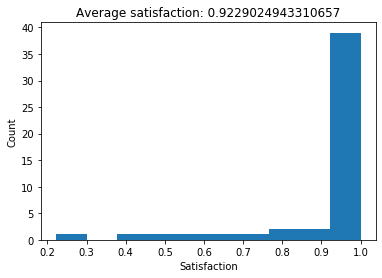

In [31]:
fig, ax = plt.subplots(1, 1)
ax.hist(student_seating_df['satisfaction']);
ax.set_title('Average satisfaction: {}'.format(np.mean(satisfaction_values)))
ax.set_xlabel('Satisfaction')
ax.set_ylabel('Count')

While this approach is simple, we can see that the distribution of satisfaction is extremely skewed.